In [1]:
%load_ext autoreload
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
from IPython.display import YouTubeVideo
import numpy as np
import math

# 門前の小僧習わぬ音源定位・分離を読む

複数のマイクを用いる事で、マイク事に届く音の違いから音源の方向や空間上の位置を推定することが可能になる。また方向がわかれば、その方向の音のみを強調することで信号を分離することが可能である。

そこで、数式とそれを計算するPythonのコードを同時にまとめて、皆が気軽に音源定位・分離を検証出来るような状況に持っていくのが本文書の目的である。

音声信号処理に関しては大学で学んだわけでも研究をして論文を書いていたわけでは無く仕事でやる必要があったので始めただけなので間違いがある可能性は多々あるのでそこは指摘していただきたい。

## 基本的な考え方

音波は音速で移動するため、距離に比例して到達する時間が異なり、一定距離を移動する間に信号に含まれる信号の周波数毎に何振幅するかが定まる。

複数のマイクを空間上に配置する際に、音源とマイクの間の距離が異なると、自ずと到達時間や振幅の位相のズレ(位相差)が生じる。時間領域で定位を行う場合は、基本的には到達時間の差を扱うことになり、周波数領域で定位を行う場合はこの位相差を用いる。

<img src="phase-delay.png">

マイクの空間的な配置と音源との位置関係からこの到達時間差・位相差をモデル化したものを、アレイマニフォールドベクトル(ステアリングベクトル)と呼ぶ。array factorと言っている人もいる。主に、ビームフォーミングのように特定の方向の音源を強調する場合に、強調したい方向を与える場合にステアリングベクトルと呼ぶようだ。よく知らんけど基本的には同じものであると思う。

これは音源からマイクまでの音の伝わり方をモデル化したものとしてその経路の伝達関数として考えることが出来る。もちろん正しく伝達関数として考えるのであれば、距離減衰等による振幅の減衰なども考慮する必要がある。この辺りは後述する計測による伝達関数の計算のところで詳細を述べる。

アレイマニフォールドベクトルを用いて周波数毎に位相を揃えることで、特定の方向の音源のパワーを計算することができ、パワーの強い方向を音源と考えることが出来る。時間領域の場合は、基本的に遅延は非整数になるので簡単には計算出来ないようにも思うが、基本的にナイキスト周波数以下の物については十分に情報が得られているはずなので、非整数遅延フィルタ等を用いることで処理することが可能になる。

取得した複数チャンネルの信号に対してアレイマニフォールドベクトルを利用すると、特定の方向の信号の強さの算出や、特定の方向から来た信号の強調が可能になる。

## アレイマニフォールドベクトル(ステアリングベクトル)

ここではマイクの配置並びに音源位置が全て同一の平面上にある場合の考える。これはそのまま三次元に拡張可能である。また、空間上の位置は考慮しない。方向のみを対象として考える。また扱うものは平面波を対象とする。平面波の場合はマイクから音源までの距離までは推定できないが、音源が入射する角度は障害物のことを考慮しなければ、マイクの相対的な位置関係からのみ推定が可能である。

基本的な定式化は以下のとおり。

マイクが空間上に配置される場合

### マイクが直線上に配置される場合


直線上に配置されたマイクアレイのアレイマニフォールドベクトルを作成するPythonのコードは以下のとおり。


### マイクが円状に配置される場合　


円周上に配置されたマイクアレイのアレイマニフォールドベクトルを作成する。

まずは原点を(0, 0)と置いた上で、各マイクの二次元座標を以下のように定義するとりあえず半径1の円周上に等間隔で8個配置するとする。

In [3]:
mics = np.array([(math.cos(math.pi / 180.0 * (360 / 8.0 * x)), math.sin(math.pi / 180.0 * (360 / 8.0 * x))) for x in range(8)])

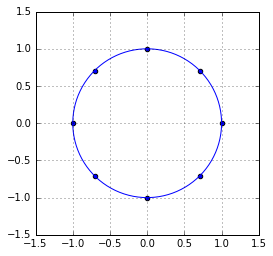

In [4]:
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(mics[:,0 ], mics[:, 1])
theta = np.linspace(-np.pi, np.pi, 200)
plt.plot(np.sin(theta), np.cos(theta))
plt.grid()

マイク$m_i$の極角度$\theta_i$、原点からの距離 $r_i$と置くと、周波数$f$に対する位相遅延は以下のように計算できる



音源入射角を$\tau$として、

### アレイマニフォールドベクトルを計測する

アレイマニフォールドベクトルは自由空間上に音源もマイクも配置されて、マイクが配置されている物体の表面を伝う波や、障害物による回折反響、壁の影響等は考慮されていない。実際の空間上に置いていろんな方向からの音声を録音して実際のデータから求めないとうまくいかないことが多いらしい。ツラミが有る。ロボットの世界や立体音響向けのパラメータとして使う場合は頭部伝達関数(Head-Related Transfer Function)というふうに呼ぶ。耳と耳たぶと頭の形状(と周辺の障害物等)に依存する伝達関数なので頭部とつく。計測を実施することにより、位相遅延だけではなく振幅の減衰についても計算することが出来、まさしく音源からマイクまでの音の伝達関数を表した物になる、

障害物だけではなく、マイクを設置する物に関しても重要で、箱や球体の表面に配置した場合などは、それがメッシュでもない限り箱の中を音が通ることは無い。音源に対して箱自体が障害物になるような場合は、上で円状マイクのアレイマニフォールドベクトルを計算した時に仮定した経路を音が通ることはなく、箱や球の表面を伝達する物と、反射波のみが観測されるため、定位はうまくいかない。計算で求めたアレイマニフォールドベクトルを使って音源定位・分離システムを作る場合は、そのマイクの配置をよく考える必要がある。


この辺りは適当に自動キャリブレーションする仕組みが欲しい所。実際教師あり学習を活用するであったり、強化学習を用いるなども有るっぽい。自分もDeep Q-Networkで音にいい感じに反応するシステムを作ろうとしている。

harkには一応計測して数値的に伝達関数を計算するツールが付属しているが計測するのはとてもダルい。

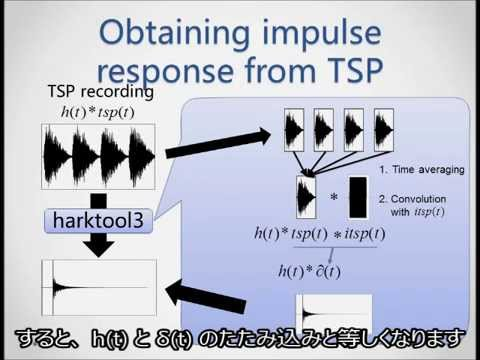

In [5]:
YouTubeVideo("rxRef-Y7NhM")

このツールで出力されるものは基本的に計測した角度・マイク位置・周波数毎の伝達関数で、テキスト形式で出力されるので他のとろこで再利用することも出来る。


## 定位を行うアルゴリズム

ここではメジャーな方法としてMUSIC(Mutiple Signal Classification)というアルゴリズムを用いる。このアルゴリズムは内部で固有値分解を必要とするため組み込み用途では計算量的な問題があるがPCでやるならそこまで大きな問題にはならないとは思う。Harkというライブラリの場合は、一定期間間を開けて計算を実施するような形で計算を間引いている。

### MUSIC Algorithm

harkのサイトの説明が分かりやすいのでそれを用いる。


# 参考文献

- 音のアレイ信号処理
  - http://www.amazon.co.jp/dp/4339011169